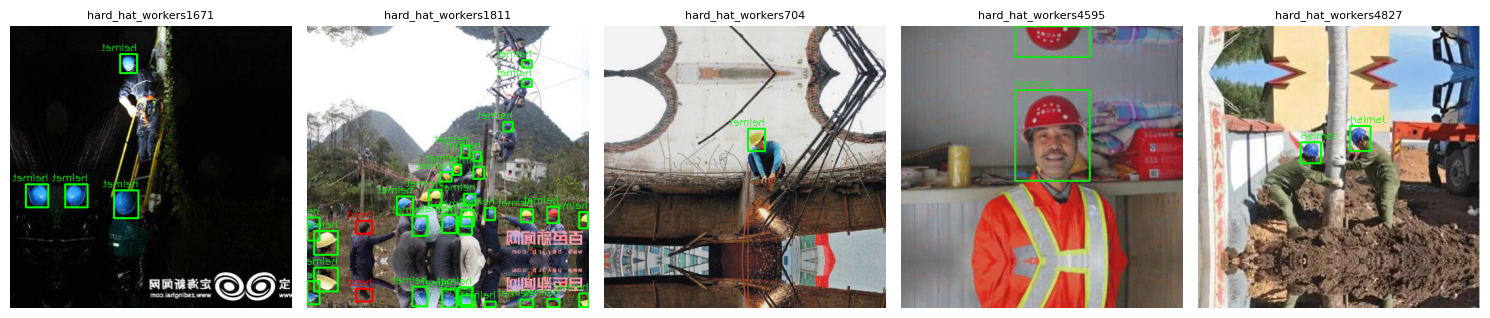

In [2]:
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image, ImageEnhance

# Dossiers
IMAGE_DIR = "images"
ANNOTATION_DIR = "annotations"
OUTPUT_DIR = "preprocessed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        box = [int(bndbox.find('xmin').text),
               int(bndbox.find('ymin').text),
               int(bndbox.find('xmax').text),
               int(bndbox.find('ymax').text)]
        boxes.append(box)
        labels.append(label)
    return boxes, labels

def draw_boxes(img, boxes, labels):
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        color = (0, 255, 0) if label in ['helmet', 'vest'] else (0, 0, 255)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img

def augment_image(img):
    img = Image.fromarray(img)
    if random.random() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(random.uniform(0.7, 1.3))
    if random.random() > 0.5:
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(random.uniform(0.7, 1.3))
    return np.array(img)

def preprocess_all():
    files = os.listdir(IMAGE_DIR)
    sample = random.sample(files, 5)
    
    plt.figure(figsize=(15, 6))  # <- AJOUTÉ
    for i, filename in enumerate(sample):
        name, _ = os.path.splitext(filename)
        img_path = os.path.join(IMAGE_DIR, filename)
        xml_path = os.path.join(ANNOTATION_DIR, name + '.xml')

        img = cv2.imread(img_path)
        boxes, labels = parse_annotation(xml_path)

        img = cv2.resize(img, (416, 416))
        img = draw_boxes(img, boxes, labels)
        aug_img = augment_image(img)

        cv2.imwrite(os.path.join(OUTPUT_DIR, f"aug_{name}.jpg"), aug_img)

        # Affichage
        plt.subplot(1, 5, i + 1)  # 1 ligne, 5 colonnes
        plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        plt.title(name, fontsize=8)  # police plus petite
        plt.axis('off')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    preprocess_all()